# Análisis de histogramas y conversión a formato ROOT

**Importación de Librerías** : Importa las librerías necesarias para el manejo de datos y gráficos.

**Funciones de Lectura y Procesamiento** : Define funciones para extraer información del encabezado (`parse_header`) y los datos de tiempo y amplitud (`extract_data`) de archivos de texto.

**Carga de Datos** : Establece la ruta al directorio de datos, identifica archivos con una expresión regular y carga los datos en un diccionario organizado por canal y número de pulso.

**Acceso a los Datos**: Muestra cómo acceder a los datos de un canal y pulso específicos (ejemplo con canal 2, pulso 00001).



In [10]:
import os
import re
import pandas as pd
import copy
import matplotlib.pyplot as plt

import numpy as np


# Function to parse the header and extract number of points
def parse_header(file_lines):
    for line in file_lines:
        if "SegmentSize" in line:
            return int(re.search(r"SegmentSize (\d+)", line).group(1))
    return None

# Function to extract data from a file
def extract_data(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()
        num_points = parse_header(lines)
        # Find the line where data starts
        start_idx = next(i for i, line in enumerate(lines) if "Time Ampl" in line) + 1
        data_lines = lines[start_idx:start_idx + num_points]
        data = [list(map(float, line.strip().split())) for line in data_lines]
        return pd.DataFrame(data, columns=['Time', 'Amplitude'])

# Path to the directory containing the files
directory_path = '/home/addles/SDR/SPILLS 1/mas datos/LYSO50mV_2'



namefile = "lyso50mv"  # nombre del archivo generado por el osciloscopio

pattern = re.compile(fr"C(\d){namefile}(\d+)\.txt")
# Dictionary to store data
data = {}

# Iterate over files in the directory
for filename in os.listdir(directory_path):
    match = pattern.match(filename)
    if match:
        channel, pulse = match.groups()
        filepath = os.path.join(directory_path, filename)
        df = extract_data(filepath)
        if channel not in data:
            data[channel] = {}
        data[channel][pulse] = df

# Example: Access data for channel 1, pulse 0001
print(data['2']['00001'])

              Time  Amplitude
0    -1.001050e-07   0.006667
1    -9.985500e-08   0.006667
2    -9.960500e-08   0.006667
3    -9.935500e-08  -0.010000
4    -9.910500e-08   0.006667
...            ...        ...
1997  3.991450e-07   0.006667
1998  3.993950e-07   0.023333
1999  3.996450e-07   0.006667
2000  3.998950e-07   0.006667
2001  4.001450e-07   0.006667

[2002 rows x 2 columns]


In [11]:
# Dividir la ruta del directorio en cada slash
parts = directory_path.split('/')

# El último elemento de la lista 'parts' es el nombre de la última carpeta
folder_name = parts[-1]

print(folder_name)


LYSO50mV_2


## Ploteo de señales 

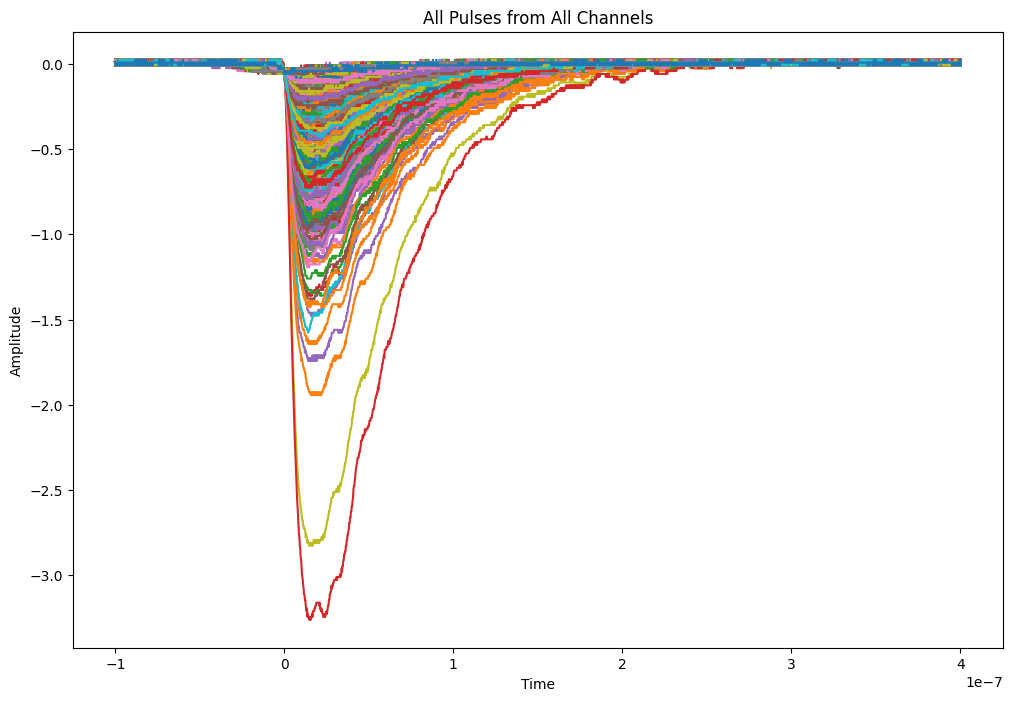

In [12]:

# Crear una figura y un eje para los gráficos
plt.figure(figsize=(12, 8))
ax = plt.gca()  # Obtener el eje actual

# Iterar sobre cada canal en los datos
for channel, pulses in data.items():
    # Iterar sobre cada pulso en el canal
    for pulse_id, df in pulses.items():
        # Trazar los datos
        ax.plot(df['Time'], df['Amplitude'])

# Configurar las etiquetas y títulos del gráfico
ax.set_title('All Pulses from All Channels')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
  # Mostrar la leyenda

# Hacer una copia profunda de 'pulses' para preservar su estado original
originalcount = copy.deepcopy(len(pulses))

# Mostrar el gráfico
plt.show()

## Filtrado y Visualización de Pulsos Válidos

Este código realiza el filtrado y la visualización de pulsos que no están saturados, según un umbral definido, y traza los pulsos válidos para todos los canales. Aspectos clave del proceso incluyen:

- **Establecimiento del umbral de saturación**: Define un umbral (Tsatur = -1.5) para identificar pulsos saturados y eliminarlos del análisis.
- **Establecimiento de ubral de corte**: para filtrar pulsos que comienzan anticipados, se cre un umbral de amplitud Tthreshold, y un umbral de tiempo Xthreshold, en donde si el pulso supera cierto umbral antes de cierto umbral de tiempo, entonces es eliminado.
- **Creación de estructuras de datos para los filtrados**: Utiliza un diccionario para almacenar los datos de pulsos que pasan el criterio de filtrado.
- **Iteración y filtrado de datos**: Recorre todos los canales y pulsos, verificando la condición de amplitud para determinar si el pulso está saturado. Los pulsos que cumplen con el criterio son almacenados y trazados.
- **Visualización de resultados**: Muestra un gráfico que representa solo los pulsos que no están afectados por la saturación, ofreciendo una visión clara de los datos válidos.

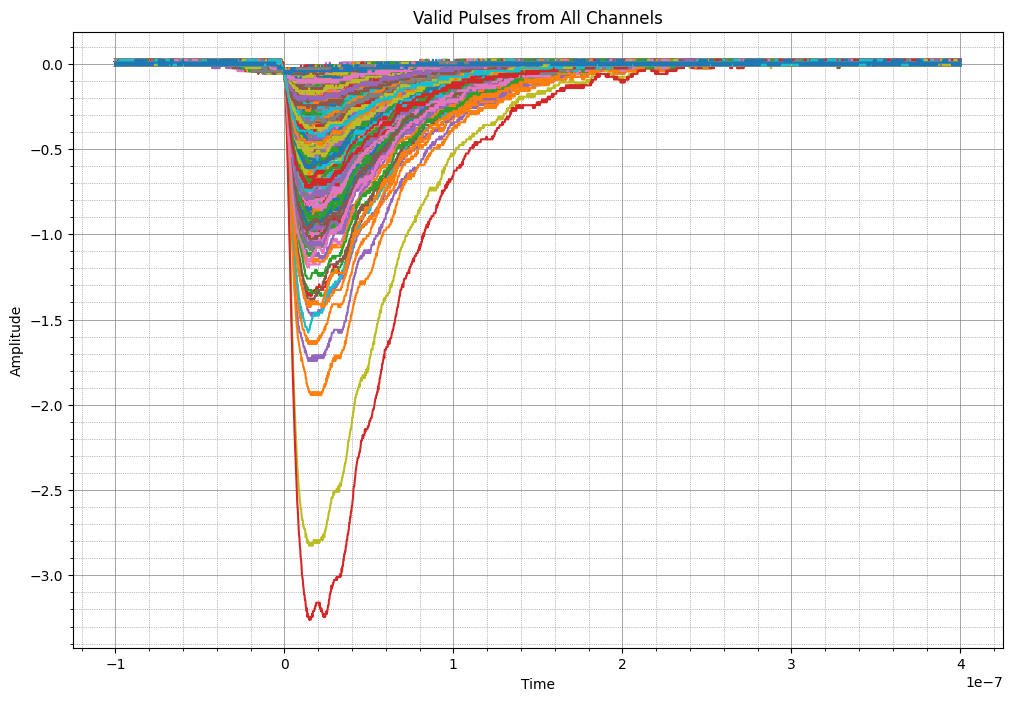

In [13]:
Tsatur = -3.5  # umbral para eliminar pulsos saturados
Tthreshold = -0.16  # umbral para verificar la amplitud que comienza a bajar
Xthreshold = -0.1e-7  # umbral en el eje x

# Crear una figura y un eje para los gráficos
plt.figure(figsize=(12, 8))
ax = plt.gca()  # Obtener el eje actual

# Diccionario para almacenar los datos filtrados
filtered_data = {}

# Iterar sobre cada canal en los datos
for channel, pulses in data.items():
    # Preparar un diccionario para los pulsos filtrados de cada canal
    filtered_data[channel] = {}
    # Iterar sobre cada pulso en el canal
    for pulse_id, df in pulses.items():
        # Verificar si algún valor de amplitud en el DataFrame cae por debajo de -1.5
        if not (df['Amplitude'] < Tsatur).any():
            # Verificar si el pulso comienza a bajar en amplitud superando el umbral 
            valid_pulse = True
            for i in range(len(df)):
                if df['Time'].iloc[i] > Xthreshold:
                    break
                if df['Amplitude'].iloc[i] < Tthreshold:
                    valid_pulse = False
                    break
            if valid_pulse:
                # Guardar los datos que pasan el filtro en el nuevo diccionario
                filtered_data[channel][pulse_id] = df
                # Trazar los datos que pasan el filtro
                ax.plot(df['Time'], df['Amplitude'])

# Configurar las etiquetas y títulos del gráfico
ax.set_title('Valid Pulses from All Channels')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')

# Configurar la grilla
ax.grid(True, which='both', linestyle='-', linewidth='0.5', color='gray')
ax.minorticks_on()  # Activar las marcas menores
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

# Mostrar el gráfico
plt.show()



## Corrección de Baseline y Comparación de Pulsos por Canal

Este código implementa un procedimiento para corregir el baseline de pulsos experimentales y visualizar comparativamente los datos originales y corregidos en subplots por canal. Proceso detallado:

- **Configuración de parámetros**: Define una ventana de tiempo para calcular la media del baseline y un umbral para descartar pulsos con un inicio sin baseline que pueden causar problemas.
- **Preparación de subplots**: Crea un arreglo de subplots con dos columnas para cada canal, donde se visualizarán los pulsos antes y después de la corrección.
- **Creación de estructuras de datos para los pulsos corregidos**: Utiliza un diccionario para almacenar los pulsos ajustados de cada canal.
- **Iteración y corrección de datos por canal**: Recorre cada canal y sus pulsos, aplicando un ajuste de baseline cuando es adecuado y trazando los datos en los subplots correspondientes.
- **Configuración individual de cada subplot**: Cada subplot recibe configuraciones de título, etiquetas y grilla para mejorar la visualización y comparación.
- **Visualización de resultados**: Muestra los gráficos resultantes, proporcionando una comparación visual entre los datos originales y los corregidos, resaltando la efectividad del ajuste de baseline.


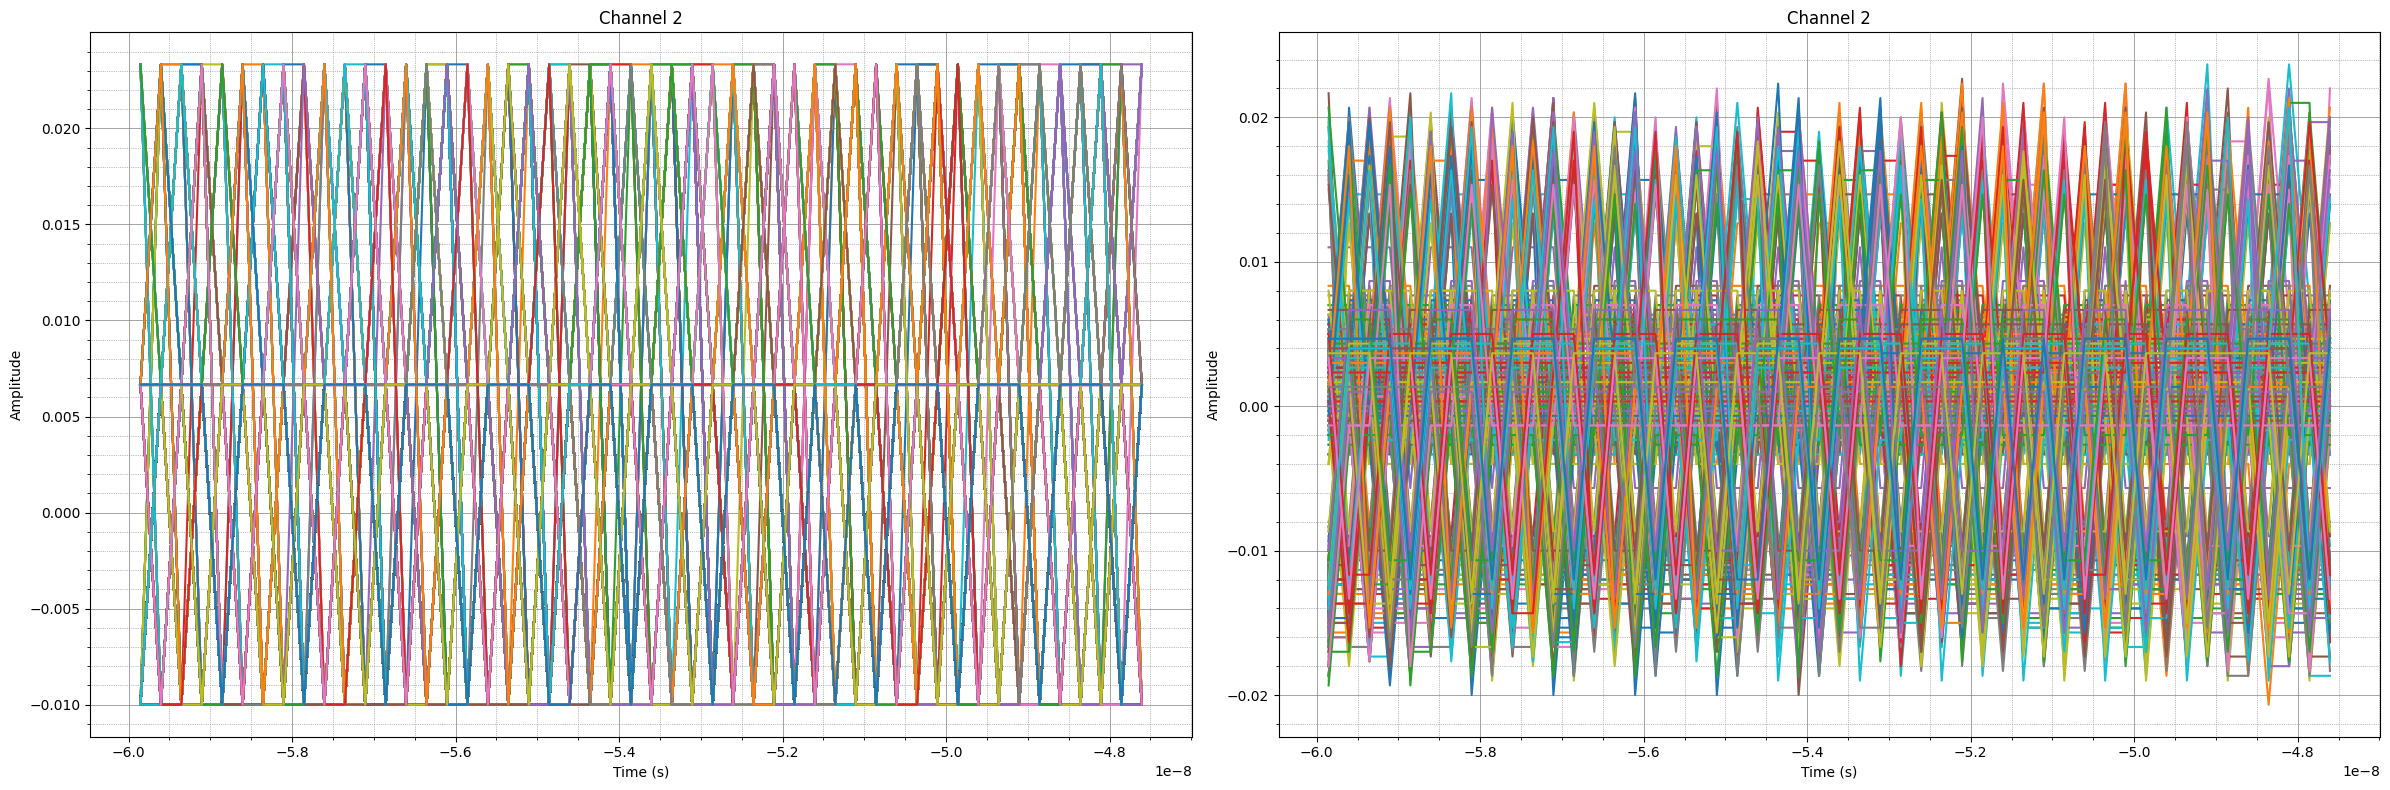

In [14]:


# Ventana de tiempo en la que se calculará la media
tiempo_inicial = -0.6e-7
ancho_ventana = 0.125e-7
tiempo_final = tiempo_inicial + ancho_ventana
# Umbral para descartar de la corrección pulsos que comienzan sin baseline
Usbaseline = -0.2

# Determinar cuántos canales únicos hay para configurar los subplots
num_channels = len(filtered_data.keys())
fig, axs = plt.subplots(num_channels, 2, figsize=(24, 8 * num_channels))  # Ajustar el tamaño según el número de canales

# Diccionario para almacenar los pulsos corregidos
corrected_data = {}

# Asegurarse de que axs sea iterable en todos los casos
if num_channels == 1:
    axs = axs.reshape(1, -1)  # Asegurarse de que axs tenga dos dimensiones

# Iterar sobre cada canal en los datos filtrados, ordenando los canales numéricamente
for ax_row, (channel, pulses) in zip(axs, sorted(filtered_data.items(), key=lambda x: int(x[0]))):
    # Preparar un diccionario para los pulsos corregidos de cada canal
    corrected_data[channel] = {}
    
    for pulse_id, df in pulses.items():
        # Encontrar índices dentro de la ventana de tiempo
        indices_ventana = (df['Time'] >= tiempo_inicial) & (df['Time'] <= tiempo_final)
        
        # Verificar el primer valor de amplitud
        if df['Amplitude'].iloc[0] < Usbaseline:
            df_corregido = df.copy()  # No se hace corrección
        else:
            # Calcular la media en la ventana especificada
            media = df.loc[indices_ventana, 'Amplitude'].mean()
            
            # Restar la media de toda la amplitud para corregir el offset
            df_corregido = df.copy()
            df_corregido['Amplitude'] -= media
        
        # Guardar el pulso corregido en el diccionario
        corrected_data[channel][pulse_id] = df_corregido

        # Trazar los datos originales y corregidos solo en la ventana de tiempo
        ax_row[0].plot(df.loc[indices_ventana, 'Time'], df.loc[indices_ventana, 'Amplitude'])
        ax_row[1].plot(df_corregido.loc[indices_ventana, 'Time'], df_corregido.loc[indices_ventana, 'Amplitude'])
    
    # Configurar las etiquetas y títulos del gráfico para cada subplot
    for ax in ax_row:
        ax.set_title(f'Channel {channel}')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.grid(True, which='both', linestyle='-', linewidth='0.5', color='gray')
        ax.minorticks_on()
        ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
       

# Ajustar el layout para evitar superposiciones
plt.tight_layout()

# Mostrar el gráfico
plt.show()


## Visualización de Pulsos Corregidos por Offset

Este código grafica los pulsos después de haber sido corregidos para eliminar desviaciones de baseline, usando subplots para cada canal.

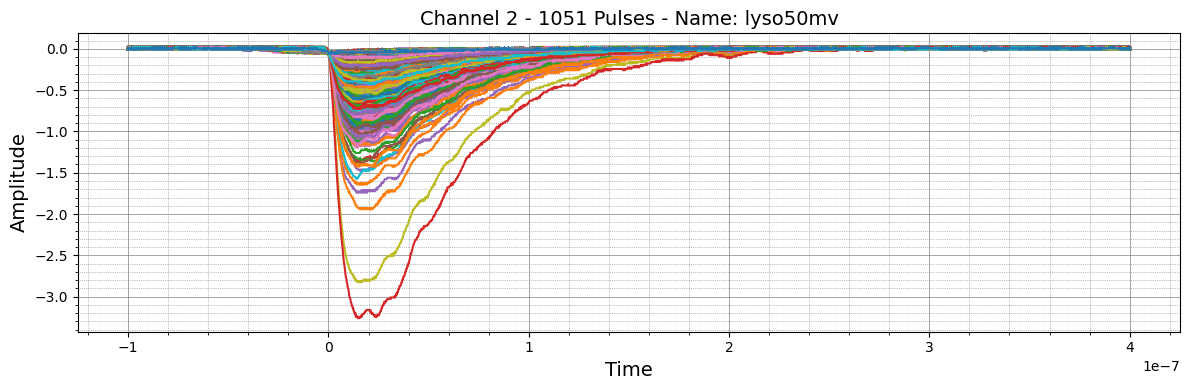

numero de pulsos  1051
Name:  lyso50mv


In [15]:


# Determinar cuántos canales únicos hay para configurar los subplots
num_channels = len(filtered_data.keys())
fig, axs = plt.subplots(num_channels, 1, figsize=(12, 4 * num_channels))  # Ajustar el tamaño según el número de canales

# Asegurarse de que axs sea iterable (en caso de que haya solo un canal)
if num_channels == 1:
    axs = [axs]

# Ordenar los canales antes de iterar (asegurando un orden secuencial)
sorted_channels = sorted(filtered_data.items(), key=lambda x: x[0])  # Ordenar por el nombre del canal

# Iterar sobre cada canal en los datos filtrados, ahora ordenados
for ax, (channel, pulses) in zip(axs, sorted_channels):
    num_pulses = len(pulses)  # Contar el número de pulsos en el canal
    # Iterar sobre cada pulso en el canal
    for pulse_id, df in pulses.items():
        # Trazar los datos
        ax.plot(df['Time'], df['Amplitude'])
        
    # Configurar las etiquetas y títulos del gráfico para cada subplot, incluyendo la cantidad de pulsos
    ax.set_title(f'Channel {channel} - {num_pulses} Pulses - Name: {namefile}', fontsize= 14 )
    ax.set_xlabel('Time',fontsize=14)
    ax.set_ylabel('Amplitude', fontsize=14)
    ax.grid(True, which='both', linestyle='-', linewidth='0.5', color='gray')
    ax.minorticks_on()
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

# Ajustar el layout para evitar superposiciones
plt.tight_layout()

# Mostrar el gráfico
plt.show()
print( "numero de pulsos ", num_pulses)
print("Name: ", namefile)

## Filtrado de Datos por Ventanas de Tiempo y Visualización por Canal

Este código filtra y visualiza datos de pulsos para cada canal dentro de ventanas de tiempo específicas, facilitando la comparación y el análisis de características particulares de los pulsos. Detalles del proceso incluyen:

- **Definición de ventanas de tiempo**: Un diccionario `time_windows` especifica los rangos de tiempo para filtrar los datos en cada canal, permitiendo ajustes personalizados según las necesidades experimentales.

- **Filtrado de datos**: Utiliza las ventanas de tiempo definidas para filtrar los pulsos en cada canal. Los datos que caen dentro de estas ventanas son almacenados en un nuevo diccionario `window_data`.


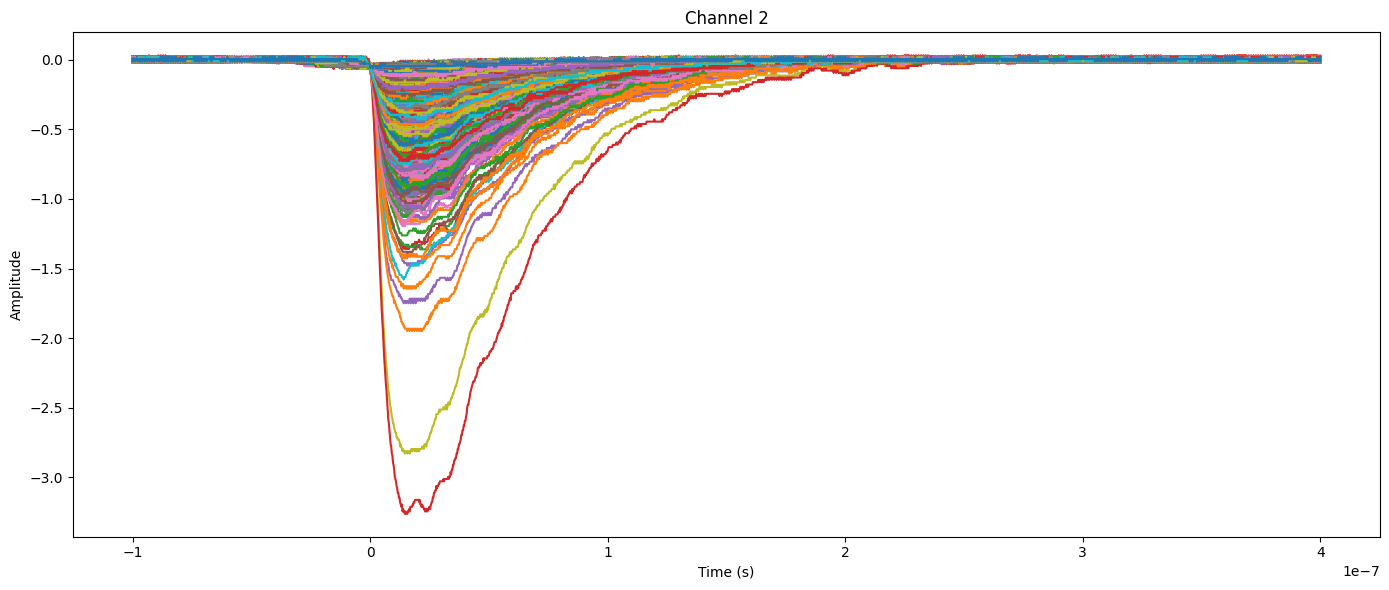

In [16]:
# Diccionario con las ventanas de tiempo para cada canal
time_windows = {
    '1': (-1e-7, 4e-7),  # Ventana para el canal 1
    '2': (-2e-7, 10e-7),
    "3": (-2e-7, 10e-7),
    "4": (-2e-7, 10e-7)## Ventana para el canal 2, puede cambiar según necesidades futuras
}

# Diccionario para almacenar los datos filtrados
window_data = {}

for channel, pulses in sorted(corrected_data.items()):
    if channel in time_windows:  # Asegurar que el canal tiene una ventana de tiempo definida
        start_time, end_time = time_windows[channel]
        window_data[channel] = {}
        for pulse_id, df in pulses.items():
            # Filtrar los datos dentro de la ventana de tiempo específica para cada canal
            filtered_df = df[(df['Time'] >= start_time) & (df['Time'] <= end_time)]
            window_data[channel][pulse_id] = filtered_df

# Determinar el número de canales y configurar la figura
num_channels = len(window_data)
fig, axes = plt.subplots(nrows=num_channels, ncols=1, figsize=(14, 6 * num_channels), squeeze=False)

# Iterar sobre cada canal y su correspondiente eje
for ax, (channel, pulses) in zip(axes.flatten(), window_data.items()):
    for pulse_id, df in pulses.items():
        # Trazar los datos en el eje correspondiente
        ax.plot(df['Time'], df['Amplitude'])
    # Configurar las etiquetas y título del subgráfico
    ax.set_title(f'Channel {channel}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
   

plt.tight_layout()
plt.show()

## Histograma de Amplitudes Máximas por Canal

Este código calcula y visualiza un histograma de las amplitudes máximas (mínimos en valor absoluto debido a amplitudes negativas) para pulsos dentro de ventanas de tiempo especificadas por canal.

- **Extracción de amplitudes máximas**: Itera sobre los pulsos de cada canal en `window_data`, extrayendo la amplitud máxima (el mínimo valor de amplitud, en este caso) de cada pulso y almacenando estos valores en un diccionario `max_amplitudes`.


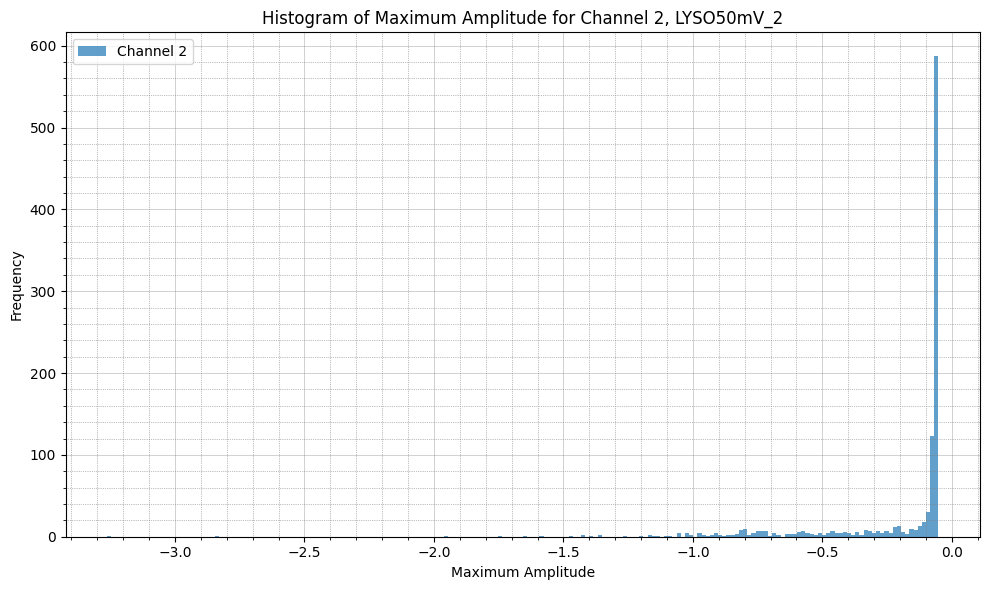

In [17]:
import matplotlib.ticker as ticker

# Diccionario para almacenar las amplitudes máximas de cada pulso
max_amplitudes = {}

for channel, pulses in window_data.items():
    max_amplitudes[channel] = []
    for pulse_id, df in pulses.items():
        # Extraer la amplitud máxima de cada pulso
        max_amplitude = df['Amplitude'].min()
        max_amplitudes[channel].append(max_amplitude)

# Configurar la figura para el histograma
num_channels = len(max_amplitudes)
fig, axes = plt.subplots(nrows=num_channels, ncols=1, figsize=(10, 6 * num_channels), squeeze=False)

# Hacer 'axes' siempre un array de numpy usando flatten(), independientemente de la cantidad de canales
axes = axes.flatten()

# Iterar sobre cada canal y su correspondiente eje
for ax, (channel, amplitudes) in zip(axes, max_amplitudes.items()):
    ax.hist(amplitudes, bins=200, alpha=0.7, label=f'Channel {channel}')
    ax.set_title(f'Histogram of Maximum Amplitude for Channel {channel}, {folder_name}')
    ax.set_xlabel('Maximum Amplitude')
    ax.set_ylabel('Frequency')
    ax.legend()
     
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.grid(True, which='major', linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.5, color='gray', alpha=1)

# Ajustar el espaciado entre los subgráficos para evitar la superposición de etiquetas y títulos
plt.tight_layout()
plt.show()


Conversion de histogramas en archivos ROOT

In [18]:
import ROOT
import uproot


# Supongamos que 'window_data' es tu diccionario de datos
max_amplitudes = {}

for channel, pulses in window_data.items():
    max_amplitudes[channel] = []
    for pulse_id, df in pulses.items():
        max_amplitude = df['Amplitude'].min()
        max_amplitudes[channel].append(max_amplitude)


# Crear un archivo ROOT para guardar los histogramas
file = ROOT.TFile(f"Histograms_{folder_name}.root", "RECREATE")

# Crear un canvas para dibujar los histogramas
canvas = ROOT.TCanvas("canvas", "Histograms of Maximum Amplitudes", 800, 600 * len(max_amplitudes))
canvas.Divide(1, len(max_amplitudes))

histograms = []
i = 1

for channel, amplitudes in max_amplitudes.items():
    if len(amplitudes) == 0:
        continue  # Saltar canales sin amplitudes
    
    # Crear un histograma para cada canal
    min_amplitude = min(amplitudes)
    max_amplitude = max(amplitudes)
    
    if min_amplitude == max_amplitude:
        max_amplitude += 1  # Para evitar problemas si todos los valores son iguales

    hist = ROOT.TH1F(f"hist_channel_{channel}", f"Histogram of Maximum Amplitude for Channel {channel}", 200, min_amplitude, max_amplitude)
    
    for amp in amplitudes:
        hist.Fill(amp)
    
    histograms.append(hist)
    canvas.cd(i)
    hist.Draw()
    hist.Write()  # Guardar el histograma en el archivo ROOT
    i += 1

canvas.Update()
canvas.Modified()
#canvas.Draw()

# Cerrar el archivo ROOT para asegurarse de que todo se escribe correctamente
file.Close()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
